In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_colwidth=100

In [2]:
def jaccard_similarity(str1, str2):
    string_set1 = set(str1.split(' '))
    string_set2 = set(str2.split(' '))
    return len(string_set1.intersection(string_set2))/len(string_set2.union(string_set1))

In [3]:
# dump pkl into a pandas dataframe. 
data = pd.read_pickle('data/string_study.pkl')

In [4]:
# data.head()

In [5]:
data["word_count"] = data._info.apply(lambda x:len(x.split(' ')))

In [6]:
# data.head()

In [9]:
class_by_len = set(data["word_count"])

In [10]:
# class_by_len

In [11]:
bin_len = len(class_by_len)
bin_len

45

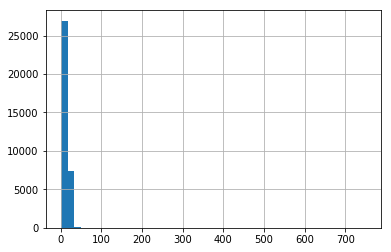

In [14]:
# Analysis of messages categorized into words
data.word_count.hist(bins = bin_len)

In [15]:
# Find the class with highest freq. 
dict = {}
for item in class_by_len:
    temp_frame = np.array(data.query("word_count == @item"))
    dict[str(item)] = len(temp_frame)

In [18]:
# The word_count with the highest frquncy is "9"
filtered_data = data.query("word_count == 21")
filtered_data.head(47)

,atime,task,deployment,raw,dtime,msg,_info,word_count
9162,1522653718630,boot-linux,wig_project_014,2018-04-02 09:21:58.630 21399 ERROR rallytester.rallytester [-] [nova boot-linux wig_project_014...,2018-04-02 07:00:00,"Unable to establish connection to https:some_url (\'Connection aborted.\', BadStatusLine(""\'\'"",))",Resource <Server: rally-e9e5-VJdA> has ERROR status. Fault: {u'message': u'Unable to establish c...,21
20215,1524045706645,boot-from-snapshot-linux,gva_project_035,2018-04-18 12:01:46.645 17144 ERROR rallytester.rallytester [-] [nova boot-from-snapshot-linux g...,2018-04-18 10:00:00,The server is currently unavailable. Please try again at a later time.<br /><br /> (HTTP 503)...,The server is currently unavailable. Please try again at a later time.<br /><br /> (HTTP 503)...,21
27306,1522919580867,reboot-linux,qa,2018-04-05 11:13:00.867 25397 ERROR rallytester.rallytester [-] [nova reboot-linux qa] Task fail...,2018-04-05 09:00:00,"Unable to establish connection to https:some_url (\'Connection aborted.\', BadStatusLine(""\'\'"",))",Resource <Server: rally-0d45-N5Bh> has ERROR status. Fault: {u'message': u'Unable to establish c...,21
27339,1522919580867,reboot-linux,qa,2018-04-05 11:13:00.867 25397 ERROR rallytester.rallytester [-] [nova reboot-linux qa] Task fail...,2018-04-05 09:00:00,"Unable to establish connection to https:some_url (\'Connection aborted.\', BadStatusLine(""\'\'"",))",Resource <Server: rally-0d45-N5Bh> has ERROR status. Fault: {u'message': u'Unable to establish c...,21
27354,1522919580867,reboot-linux,qa,2018-04-05 11:13:00.867 25397 ERROR rallytester.rallytester [-] [nova reboot-linux qa] Task fail...,2018-04-05 09:00:00,"Unable to establish connection to https:some_url (\'Connection aborted.\', BadStatusLine(""\'\'"",))",Resource <Server: rally-0d45-N5Bh> has ERROR status. Fault: {u'message': u'Unable to establish c...,21
27399,1522919580867,reboot-linux,qa,2018-04-05 11:13:00.867 25397 ERROR rallytester.rallytester [-] [nova reboot-linux qa] Task fail...,2018-04-05 09:00:00,"Unable to establish connection to https:some_url (\'Connection aborted.\', BadStatusLine(""\'\'"",))",Resource <Server: rally-0d45-N5Bh> has ERROR status. Fault: {u'message': u'Unable to establish c...,21
27453,1522919580867,reboot-linux,qa,2018-04-05 11:13:00.867 25397 ERROR rallytester.rallytester [-] [nova reboot-linux qa] Task fail...,2018-04-05 09:00:00,"Unable to establish connection to https:some_url (\'Connection aborted.\', BadStatusLine(""\'\'"",))",Resource <Server: rally-0d45-N5Bh> has ERROR status. Fault: {u'message': u'Unable to establish c...,21
27582,1522919580867,reboot-linux,qa,2018-04-05 11:13:00.867 25397 ERROR rallytester.rallytester [-] [nova reboot-linux qa] Task fail...,2018-04-05 09:00:00,"Unable to establish connection to https:some_url (\'Connection aborted.\', BadStatusLine(""\'\'"",))",Resource <Server: rally-0d45-N5Bh> has ERROR status. Fault: {u'message': u'Unable to establish c...,21
27690,1522919580867,reboot-linux,qa,2018-04-05 11:13:00.867 25397 ERROR rallytester.rallytester [-] [nova reboot-linux qa] Task fail...,2018-04-05 09:00:00,"Unable to establish connection to https:some_url (\'Connection aborted.\', BadStatusLine(""\'\'"",))",Resource <Server: rally-0d45-N5Bh> has ERROR status. Fault: {u'message': u'Unable to establish c...,21
27762,1522919580867,reboot-linux,qa,2018-04-05 11:13:00.867 25397 ERROR rallytester.rallytester [-] [nova reboot-linux qa] Task fail...,2018-04-05 09:00:00,"Unable to establish connection to https:some_url (\'Connection aborted.\', BadStatusLine(""\'\'"",))",Resource <Server: rally-0d45-N5Bh> has ERROR status. Fault: {u'message': u'Unable to establish c...,21


In [19]:
msg_array = np.array(filtered_data._info.copy())
# msg_array

In [20]:
msg_array = np.array(filtered_data._info.copy())
jaccard_sim_set = []
jaccard_matrix = [[0 for i in range(len(msg_array))] for j in range(len(msg_array))]
for i in range(0, len(msg_array)):
    jaccard_matrix[i][i] = 1
    for j in range(i+1, len(msg_array)):
        jaccard_sim = jaccard_similarity(msg_array[i], msg_array[j])
        jaccard_sim_set.append(jaccard_sim)
        jaccard_matrix[i][j] = jaccard_sim
        jaccard_matrix[j][i] = jaccard_sim

In [22]:
# set(jaccard_sim_set)


In [23]:
len(set(jaccard_sim_set))

10

In [24]:
jaccard_dataframe = pd.DataFrame(jaccard_sim_set)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120e67470>]],
      dtype=object)

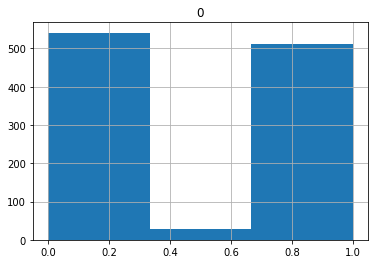

In [25]:
jaccard_dataframe.hist(bins = 3)

In [26]:
jaccard_matrix[-1][-3] 

0.3125

#      Minhashing starts here


In [27]:
# Shingle generators 
# Arguments : Message string, shingle size {in words}
# Returns : All shingles formed with k words
def shingle_generator(message, k):
    message = message.split(' ')
    item_set = []
    for i in range(0, len(message)-k):
        shingle =  ""
        for j in range(0, k):
            shingle = shingle + message[i+j] + " "
        item_set.append(shingle)
    return item_set

In [28]:
raw_msgs = filtered_data._info

In [29]:
# Generate the set of words of all raw messages
message_set = []
# %time

for item in np.array(raw_msgs):
#     print(item)
    item = str(item)
    set_of_words = set(item.split(' '))
    # Shingle size is set to 3 words
    set_of_words = set(shingle_generator(item, 2))
    message_set.append(set_of_words)

In [30]:
import numpy as np
import csv
import pandas
from datasketch import MinHash, MinHashLSH

In [31]:
# Generate MinHash instances for all messages
m = []
for i in range (0, len(message_set)):
    m_temp = MinHash(num_perm=128)
    m.append(m_temp)
len(m)

47

In [41]:
i = 0
for message in message_set:
    for word in message:
        m[i].update(word.encode('utf-8'))
    i = i + 1

# Create an LSH indexb
# %time
lsh = MinHashLSH(threshold=.4, num_perm=128)
count = 0
for i in range (0, len(m)):
    string = "m" + str(i)
    lsh.insert(string, m[i])
    count += 1

In [42]:
# Find all the messages similar to the fist message with a specified threshold
result = lsh.query(m[0])
# (result)

In [43]:
# Repeat the clustering proc for every message. 
clusters = {}
cluster_count = 1
# For every message add the result to the cluster
for i in range(0, len(m)):
    # check if the message belongs to any cluster
    msg_str = "m" + str(i)
    flag = 1
    for item in clusters.values():
        if msg_str in item:
            flag = 0
            break
    # End of check box
    if flag:
        result = lsh.query(m[i])
        clusters[cluster_count] = result
        cluster_count += 1

In [44]:
clusters

{1: ['m15',
  'm17',
  'm26',
  'm20',
  'm11',
  'm28',
  'm25',
  'm3',
  'm5',
  'm16',
  'm10',
  'm24',
  'm22',
  'm14',
  'm9',
  'm2',
  'm12',
  'm21',
  'm18',
  'm29',
  'm23',
  'm8',
  'm27',
  'm7',
  'm19',
  'm6',
  'm0',
  'm13',
  'm4'],
 2: ['m1'],
 3: ['m43',
  'm40',
  'm35',
  'm38',
  'm31',
  'm36',
  'm30',
  'm39',
  'm41',
  'm33',
  'm37',
  'm34',
  'm44',
  'm32',
  'm42'],
 4: ['m45'],
 5: ['m15',
  'm17',
  'm26',
  'm20',
  'm11',
  'm28',
  'm25',
  'm3',
  'm5',
  'm16',
  'm10',
  'm24',
  'm22',
  'm14',
  'm9',
  'm2',
  'm12',
  'm21',
  'm18',
  'm29',
  'm23',
  'm8',
  'm27',
  'm7',
  'm6',
  'm46',
  'm13',
  'm4']}